=== DistilBERT Evaluation ===
              precision    recall  f1-score   support

        mild     0.6190    0.3611    0.4561        36
        safe     0.7073    1.0000    0.8286        58
      severe     1.0000    0.7500    0.8571         4
       toxic     0.8889    0.4706    0.6154        17

    accuracy                         0.7130       115
   macro avg     0.8038    0.6454    0.6893       115
weighted avg     0.7167    0.7130    0.6815       115



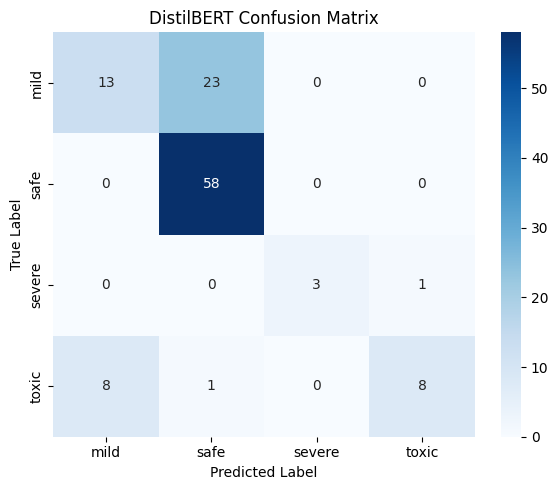

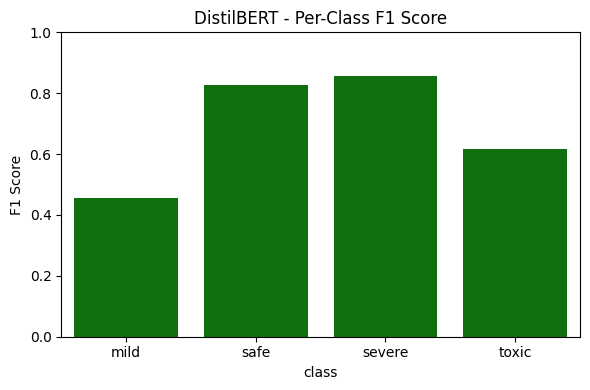


Metrics saved to ../results/metrics/phase2_distilBert_metrics_forum_based_comments.json


In [3]:
# =============================
# 02. DistilBERT Experiments (Fixed)
# =============================

import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

# ===================================
# Paths
# ===================================
# You can point this to either processed or test CSV
DATA_PATH = "../data/test/forum_test_dataset.csv"
MODEL_PATH = "../models/saved/bert"

# ===================================
# Load Data
# ===================================
df = pd.read_csv(DATA_PATH)

# Detect which columns are available
if "text" in df.columns and "label" in df.columns:
    X = df["text"].tolist()
    y = df["label"].tolist()
elif "cleaned_comment" in df.columns and "expected_label" in df.columns:
    X = df["cleaned_comment"].tolist()
    y = df["expected_label"].tolist()
else:
    raise ValueError("CSV must contain either ('text','label') or ('cleaned_comment','expected_label') columns.")

# ===================================
# Load Fine-Tuned DistilBERT Model
# ===================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(MODEL_PATH, "checkpoint-17500"))
model.eval()

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ===================================
# Load Labels from Model
# ===================================
id2label = joblib.load(os.path.join(MODEL_PATH, "id2label.pkl"))
label2id = joblib.load(os.path.join(MODEL_PATH, "label2id.pkl"))

class_names = [id2label[i] for i in range(len(id2label))]
num_labels = len(class_names)

# ===================================
# Tokenize and Predict in Batches
# ===================================
batch_size = 16
preds = []
true_labels = []

for i in range(0, len(X), batch_size):
    batch_texts = X[i:i + batch_size]
    batch_labels = y[i:i + batch_size]
    
    encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(predictions)
        true_labels.extend(batch_labels)

# ===================================
# Decode Predictions
# ===================================
y_pred = [id2label[p] for p in preds]

# ===================================
# Classification Report
# ===================================
print("=== DistilBERT Evaluation ===")
print(classification_report(true_labels, y_pred, target_names=class_names, digits=4))

# ===================================
# Confusion Matrix
# ===================================
cm = confusion_matrix(true_labels, y_pred, labels=class_names)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===================================
# Per-Class F1 Visualization
# ===================================
report = classification_report(true_labels, y_pred, target_names=class_names, output_dict=True)
f1_scores = [report[label]['f1-score'] for label in class_names]

df_f1 = pd.DataFrame({
    "class": class_names,
    "f1_score": f1_scores
})

plt.figure(figsize=(6, 4))
sns.barplot(data=df_f1, x="class", y="f1_score", color="green")
plt.title("DistilBERT - Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ===================================
# Save Metrics
# ===================================
results_dir = "../results/metrics"
os.makedirs(results_dir, exist_ok=True)

results = {
    "model": "DistilBERT",
    "accuracy": np.mean(np.array(true_labels) == np.array(y_pred)),
    "macro_f1": np.mean(f1_scores),
    "per_class_f1": {label: float(report[label]['f1-score']) for label in class_names}
}

out_path = os.path.join(results_dir, "phase2_distilBert_metrics_forum_based_comments.json")
with open(out_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\nMetrics saved to {out_path}")